# LDA


We will compare three linear classification algorithms - the Perceptron, the Nearest Centroid Classifier (NCC) and the Linear Discriminant Analysis (LDA). This comparision is done on a toy data set and on two different real data sets - the USPS data, and a Brain-Computer Interface (BCI) data set. 

The BCI data set consists of preprocessed EEG data $X \in\mathbb{R}^{5 \times 62 \times 5322}$ and stimulus labels $Y \in\mathbb R^{2 \times 5322}$ during a copy-spelling paradigm with a P300 speller. The data matrix $X$ contains 5 selected time windows of EEG activity at 62 electrodes after a visual stimulus was presented on the screen in front of the participant. If the first row of $Y$ is 1, the stimulus was a target stimulus, if the second row of $Y$ is 1, the stimulus was a non-target stimulus. The goal is to predict if the simulus was a target or not given the EEG.     

In [2]:
import scipy as sp
import scipy.io as io
from scipy.linalg import inv
import pylab as pl
%matplotlib inline

In the function ```train_lda``` we implement a linear discriminant analysis (LDA) classifer, that is, find a 
vector $\mathbf{w}$ such that  
$$\mathbf{w} = \underset{\mathbf{w}}{\text{argmax}} \; \frac{\mathbf{w}^T S_B \mathbf{w}}{\mathbf{w}^T S_{W} \mathbf{w}}$$
where $S_B$ denotes the 'between-class scatter' and $S_W$ denotes the 'within-class scatter'
\begin{eqnarray*}
S_B &= & (\mathbf w_+ - \mathbf w_{-})(\mathbf w_+ - \mathbf w_{-})^T \\
S_W &= & \frac{1}{N_{+}} \sum_{i=1}^{N_{+}}(\mathbf x_{+i} - \mathbf w_{+})  (\mathbf x_{+i} - \mathbf w_{+})^T + \frac{1}{N_{-}} \sum_{i=1}^{N_{-}}(\mathbf x_{-i} - \mathbf w_{-})  (\mathbf x_{-i} - \mathbf w_{-})^T
\end{eqnarray*}
and $\mathbf w_{+}$, $\mathbf w_{-}$ denote the respective class means.

In [3]:
def train_lda(X,Y):
    ''' Trains a linear discriminant analysis
    Definition:  w, b   = train_lda(X,Y)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
    Output:      w       -  1D array of length D, weight vector  
                 b       -  bias term for linear classification                          
    '''
    
    X_target= X[:,Y == 1]
    X_nonTarget = X[:,Y==-1]
    
    target_mean = sp.mean(X_target, axis = 1)
    nonTarget_mean = sp.mean(X_nonTarget, axis = 1)
    S_w = sp.cov(X_target) + sp.cov(X_nonTarget)
    w = sp.dot(sp.linalg.inv(S_w),(target_mean - nonTarget_mean))
    b = 0.5 * sp.dot(w.T,(target_mean - nonTarget_mean)) + (sp.log(X_nonTarget.shape[1] / X_target.shape[1]))
    
    return w,b
    
    
    
def load_usps_data(fname, digit=3):
    ''' Loads USPS (United State Postal Service) data from <fname> 
    Definition:  X, Y = load_usps_data(fname, digit = 3)
    Input:       fname   - string
                 digit   - optional, integer between 0 and 9, default is 3
    Output:      X       -  DxN array with N images with D pixels
                 Y       -  1D array of length N of class labels
                             (1 - picture displays <digit>, -1 - otherwise)                           
    '''
    # load the data
    data = io.loadmat(fname)
    # extract images and labels
    X = data['data_patterns']
    Y = data['data_labels']
    Y = Y[digit,:]
    return X, Y
    
    
def load_bci_data(fname):
    ''' Loads BCI data (one subject, copy-spelling experiment) from <fname> 
    Definition:  X, Y = load_bci_data(fname)
    Input:       fname   - string
    Output:      X       -  DxN array with N images with D pixels
                 Y       -  1D array of length N of class labels 
                            (1- target, -1 - non-target)                         
    '''
    # load the data
    data = io.loadmat(fname)
    # extract time-electrode features and labels
    X = data['X']
    Y = data['Y']
    # collapse the time-electrode dimensions
    X = sp.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    # transform the labels to (-1,1)
    Y = sp.sign((Y[0,:]>0) -.5)
    return X,Y

def train_perceptron(X,Y,iterations=200,eta=.1):
    ''' Trains a linear perceptron
    Definition:  w, b, acc  = train_perceptron(X,Y,iterations=200,eta=.1)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
                 iter    -  optional, number of iterations, default 200
                 eta     -  optional, learning rate, default 0.1
    Output:      w       -  1D array of length D, weight vector 
                 b       -  bias term for linear classification                          
    '''
    #include the bias term by adding a row of ones to X 
    X = sp.concatenate((sp.ones((1,X.shape[1])), X))
    #initialize weight vector
    weights = sp.ones((X.shape[0]))/X.shape[0]
    for it in sp.arange(iterations):
        # indices of misclassified data
        wrong = (sp.sign(weights.dot(X)) != Y).nonzero()[0]
        if wrong.shape[0] > 0:
            # pick a random misclassified data point
            m = wrong[sp.random.randint(0, wrong.shape[0]-1)]
            #update weight vector (use variable learning rate (eta/(1.+it)) )
            weights = weights  + (eta/(1.+it)) * X[:, m] * Y[m]; 
            # compute accuracy
            wrong = (sp.sign(weights.dot(X)) != Y).nonzero()[0]
    b = -weights[0] 
    w = weights[1:]
    return w,b

def train_ncc(X,Y):
    ''' Trains a nearest centroid classifier
    Definition:  w, b   = train_ncc(X,Y)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
    Output:      w       -  1D array of length D, weight vector  
                 b       -  bias term for linear classification                          
    '''
    #class means
    mupos = sp.mean(X[:,Y>0],axis=1)
    muneg = sp.mean(X[:,Y<0],axis=1)
    #weight vector and bias term
    w = mupos - muneg
    b = (w.dot(mupos) + w.dot(muneg))/2.
    return w,b
    
def plot_histogram(X, Y, w, b, cname):
    ''' Plots a histogram of classifier outputs (w^T X) for each class 
    Input:          X       -  DxN array of N data points with D features
                    Y       -  1D array of length N of class labels
                    w       -  1D array of length D, weight vector 
                    b       -  bias term for linear classification  
                    cname   - name of the classifier 
    '''
    pl.hist((w.dot(X[:,Y<0]), w.dot(X[:,Y>0])))
    pl.xlabel("w^T X")
    pl.title(cname + ' ' + str(100*sp.sum(sp.sign(w.dot(X)-b)==Y)/X.shape[1]) + "%")   
     
def compare_classifiers_toy():
    '''
    Compares 3 different linear classifiers (Nearest-Centroid, Linear Discriminant Analysis, 
    Perceptron) on 2 dimensional toy data
    '''
    #generate 2D data
    N =500
    cov = sp.array([[5, 0], [0, 0.5]])
    x1 = sp.random.multivariate_normal([-0.5, -0.5], cov, N) 
    x2 = sp.random.multivariate_normal([2.5, 0.5], cov, N) 
    X = sp.vstack((x1, x2)).transpose()
    Y = sp.hstack((sp.ones((N)), -1*sp.ones((N))))
    
    #train NCC, LDA and Perceptron
    w_ncc,b_ncc = train_ncc(X,Y)
    w_lda,b_lda = train_lda(X,Y)
    w_per,b_per = train_perceptron(X,Y)
       
    #plot result
    pl.figure()
    b_ncc = 10*b_ncc / sp.linalg.norm(w_ncc)
    b_lda = 10*b_lda / sp.linalg.norm(w_lda)
    b_per = 10*b_per / sp.linalg.norm(w_per)
    w_lda = 10*w_lda / sp.linalg.norm(w_lda)
    w_ncc = 10*w_ncc / sp.linalg.norm(w_ncc)
    w_per = 10*w_per / sp.linalg.norm(w_per)
    pl.plot([-w_lda[1], w_lda[1]], [w_lda[0]+b_lda/w_lda[1], -w_lda[0]+b_lda/w_lda[1]], 
        color = 'k', label='LDA: Acc ' + str(100*sp.sum(sp.sign(w_lda.dot(X)-b_lda)==Y)/X.shape[1]) + "%")
    pl.plot([-w_ncc[1], w_ncc[1]], [w_ncc[0]+b_ncc/w_ncc[1], -w_ncc[0]+b_ncc/w_ncc[1]], 
        color = 'r', linestyle = '--', label='NCC: Acc ' + str(100*sp.sum(sp.sign(w_ncc.dot(X)-b_ncc)==Y)/X.shape[1]) + "%")
    pl.plot([-w_per[1], w_per[1]], [w_per[0]+b_per/w_per[1], -w_per[0]+b_per/w_per[1]], 
        color = 'g', linestyle = ':', label='PER: Acc ' + str(100*sp.sum(sp.sign(w_per.dot(X)-b_per)==Y)/X.shape[1]) + "%")
    pl.plot(x1[:,0], x1[:,1], 'y+')
    pl.plot(x2[:,0], x2[:,1], 'b+')
    pl.axis('equal')
    pl.legend(loc=1)

def compare_classifiers(usps = True, digit = 3):
    '''
    Compares 3 different linear classifiers (Nearest-Centroid, Linear Discriminant Analysis, 
    Perceptron) on either USPS data (for usps=True) or on BCI data (for usps = False)
    '''
    if usps: #load usps data set
        X,Y = load_usps_data('usps.mat',digit)
        tit = 'USPS(' + str(digit) + ')'
    else: #load bci data set 
        X,Y = load_bci_data('bcidata.mat')
        tit = 'BCI'
    
    #Use crossvalidation to estimate the training and test accuracies
    acc_cv = sp.zeros((5, 6))
    (acc_cv[:,0],acc_cv[:,1]) = crossvalidate(X,Y,trainfun=train_ncc)
    (acc_cv[:,2],acc_cv[:,3]) = crossvalidate(X,Y,trainfun=train_lda)
    (acc_cv[:,4],acc_cv[:,5]) = crossvalidate(X,Y,trainfun=train_perceptron)
        
    #Plot the crossvalidation output
    pl.figure()
    ax1 = pl.subplot2grid((2,3), (0,0), colspan = 3)
    pl.bar(sp.array([1, 2, 3, 4, 5, 6]) - 0.4,  acc_cv.mean(0), width = 0.8,
        yerr =  acc_cv.std(0), ecolor = 'k', color = 'g')
    pl.xticks([1, 2, 3, 4, 5, 6], ['NCC tain', 'NCC test', 'LDA train', 'LDA test', 
        'PER train', 'PER test'])
    pl.xlim([0, 7])
    pl.ylim([0.5, 1])
    pl.ylabel('CV Accuracy')
    pl.title(tit + ' data set')

    #Train the classifiers and plot the output histograms
    w_ncc,b_ncc = train_ncc(X,Y)
    w_lda,b_lda = train_lda(X,Y)
    w_per,b_per= train_perceptron(X,Y)
    
    ax2 = pl.subplot2grid((2,3), (1,0))
    plot_histogram(X, Y, w_ncc, b_ncc, 'NCC')
    ax3 = pl.subplot2grid((2,3), (1,1))
    plot_histogram(X, Y, w_lda, b_lda, 'LDA')
    ax4 = pl.subplot2grid((2,3), (1,2))
    plot_histogram(X, Y, w_per, b_per, 'PER')

def crossvalidate(X,Y, f=5, trainfun=train_ncc):
    ''' 
    Test generalization performance of a linear classifier by crossvalidation
    Definition:     crossvalidate(X,Y, f=5, trainfun=train_ncc)
    Input:      X        -  DxN array of N data points with D features
                Y        -  1D array of length N of class labels
                f        - number of cross-validation folds
                trainfun - function for linear classification training
    Output:     acc_train - (f,) array of accuracies in test train folds
                acc_test  - (f,) array of accuracies in each test fold
    '''
    '''
    
    N = f*(X.shape[-1]/f)
    idx = sp.reshape(sp.arange(N),(f,N/f))
    '''
    N = f*(X.shape[-1]//f)
    idx = sp.reshape(sp.arange(N),(f,N//f))
    
    acc_train = sp.zeros((f))
    acc_test = sp.zeros((f))
    
    for ifold in sp.arange(f):
        testidx = sp.zeros((f),dtype=bool)
        testidx[ifold] = 1
        test = idx[testidx,:].flatten()
        train = idx[~testidx,:].flatten()
        w,b = trainfun(X[:,train],Y[train])
        acc_train[ifold] = sp.sum(sp.sign(w.dot(X[:,train])-b)==Y[train])/sp.double(train.shape[0])
        acc_test[ifold] = sp.sum(sp.sign(w.dot(X[:,test])-b)==Y[test])/sp.double(test.shape[0])
    
    return acc_train,acc_test

We test your LDA implementation with the function ```compare_classifiers_toy```. It generates a 2D toy data set and plots the resulting separating hyperplanes for the three linear classification methods. 

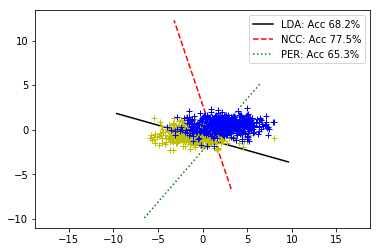

In [6]:
compare_classifiers_toy()

A few things to notice:

a) The perceptron seems to behave differently each time (as opposed to the LDA and NCC which behave roughly the same
   in each interation). Its (the perceptron's) classification hyperplane as well as its classification accuracy vary
   substantially from run to run.
   Explanation: The algorithm implementing the perceptron uses a random misclassified data-vector to update the
   weight-vector which (in combination with a finite number of update-iterations in the training-phase) can produce
   different results for each run of the program.
   
b) The algorithm we used to implement the LDA assumes equal covariance matrizes of the two data classes. The data is
   generated using the same covariance matrix which makes the LDA algorithm optimal for this type of data.
   
c) LDA first decorrelates the data followed by a nearest centroid classification. To generate uncorrelated data one
   has to use a diagonal covariance matrix. This is what would have to be changed in order for the two classification
   algorithms (LDA and NCC) to yield the same result.

Now, we compare LDA with the Perceptron and the NC-classifier on the USPS dataset. 

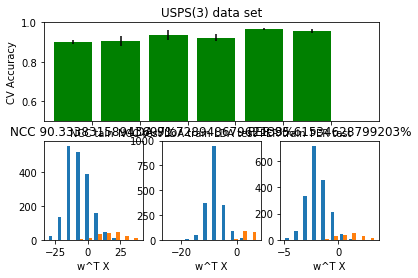

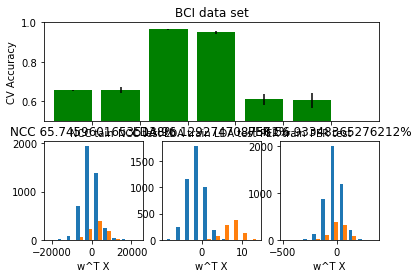

In [9]:
compare_classifiers()
compare_classifiers(False)

Something to notice:
For the BCI dataset LDA clearly outperforms the other two classification methods. So here, LDA is clearly preferable
over NCC and Perceptron. The reason for this being the distribution of the data. There seems to be a certain 'view' on
the data that separates the means quite well.
The perceptron algorithm outperforms the other two for certain digits in the usps-dataset (the more 'complicated' digits).
Here, the reason might be the (roughly) uniform distribution of digits in the dataset (LDA favors a gaussian distribtion)
and high within-class-variance of the images (which the perceptron handles better than the nearest centroid classifier).

### A note about crossvalidation

Cross validation is usually used to validate certain hyper-parameters of machine-learning models (e.g. the number
of units in a hidden layer of a neural network etc.). It works as follows. Assuming you have a data-set of labelled training data and are unsure which split you should use in terms of the percentage of the data-set used to train your model and the percentage used to validate it. Crossvalidation now uses a number of splits (10, say) of the whole dataset and trains the model exactly the number of times the dataset was split into (10 in our case) and later averages the results (for example the classification vector of a Perceptron) over all training-phases (again, 10). The trick is that each time another 10th of the dataset is set aside to be the validation data and the model is trained on the remaining 9 10ths. For example: the first training is done with 10ths number 1 through 9 of the whole dataset, and validation with 10th number 10. The next training is done with 10ths number 1 through 8 of and 10 of the whole dataset and validation with 10th number 9; and so on.

The goal of training (for example in classification) is always generalization. This means that a model that was trained on one data-set (the training data) should also perform well on another data-set that it was not trained with (the test data) in order to be considered a good model. A model showing 100% training accuracy but poor test accuracy is subject to what is called overfitting which means poor generalization an thus poor performance on unknown data. So when comparing two models one should look at the test-accuracies.